# Sentinel-1 processing for ship detection (SNAP)

In  this  tutorial  we  will employ `eodag` for ship  detection (marine  surveillance) in the Gulf of Trieste   using Sentinel-1 satellite-borne Synthetic Aperture Radar (SAR).

Marine surveillance can be done using different technologies. A first option consists of cooperative system in which ships themselves report their identities and positions. The three most common options are Automatic Identification System (AIS), Long Range Identification and Tracking (LRIT) and Vessel Monitoring System. These systems most commonly use cameras and radars located on a variety of platforms (ship, airplanes, satellites, etc.) (source: [ESA RUS](https://rus-training.eu/) tutorials).

Ship detection with Sentinel-1 falls into the non-cooperative category and enables detection of vessels not carrying AIS or other tracking system on board such as smaller fishing ships or ships that are in the surveyed area illegally (illegal fishing, piracy etc.). Moreover, SAR is not reliant on solar illumination and is rather   independent of weather conditions, therefore enabling frequent monitoring.


To be able to follow this tutorial, you will need to:

* [SNAP](http://step.esa.int/main/download/snap-download/) to use its `gpt` command. This particular command is used to execute *SNAP* raster data operators in batch-mode based on XML Graph files (see more info about the [Graph Processing Framework](https://senbox.atlassian.net/wiki/spaces/SNAP/pages/70503590/Creating+a+GPF+Graph) of *SNAP*). You need to have the `bin` folder of *SNAP* in your system *PATH*. The version used in this tutorial is the 8.0.
* Download the auxiliary files [here](https://github.com/CS-SI/eodag/tree/master/examples/auxdata/) which contain the appropriate shapefiles.
* The following Python packages: [Folium](https://python-visualization.github.io/folium/installing.html), [imageio](https://imageio.readthedocs.io/en/stable/installation.html), [Matplotlib](https://matplotlib.org/3.3.3/users/installing.html), [NumPy](https://numpy.org/install/) and [rasterio](https://rasterio.readthedocs.io/en/latest/installation.html).

## Configuration

Let's start by setting your personal credentials to access [PEPS service](https://peps.cnes.fr/rocket/) by filling your username and password below:

In [1]:
import os
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = "PLEASE_CHANGE_ME"
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = "PLEASE_CHANGE_ME"

If you don't have the `bin` folder of *SNAP* in your system *PATH* uncomment the following lines of code, adapt the path to your installation and run it to check whether the path was correctly prepended to your *PATH*.

In [2]:
# Add absolute path to SNAP bin folder to make the gpt command available 
#os.environ["PATH"] = "PLEASE_CHANGE_ME" + ":" + os.environ["PATH"]

Let's check that the Python packages required to run this notebook are available:

In [3]:
import folium
import imageio
import matplotlib.pyplot as plt
import numpy as np
import rasterio

Then we create a workspace directory where all our files and configuration will live:

In [4]:
from eodag.api.core import EODataAccessGateway
from eodag import setup_logging

setup_logging(verbose=2)

# Create the workspace folder.
workspace = 'eodag_workspace_shipdetection'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

# Save the PEPS configuration file.
yaml_content = """
peps:
    download:
        outputs_prefix: "{}"
        extract: true
""".format(os.path.abspath(workspace))

with open(os.path.join(workspace, 'eodag_conf.yml'), "w") as f_yml:
    f_yml.write(yaml_content.strip())

dag = EODataAccessGateway(os.path.join(workspace, 'eodag_conf.yml'))

2021-01-11 21:29:05,764-15s eodag.config                     [INFO    ] Loading user configuration from: /home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace_shipdetection/eodag_conf.yml
2021-01-11 21:29:06,075-15s eodag.core                       [INFO    ] Locations configuration loaded from /home/maxime/.config/eodag/locations.yml


## Search and download with `eodag`

We define the type of product we want to work on and the search area.

In [5]:
product_type = 'S1_SAR_GRD'
extent = {
    'lonmin': 13.054504,
    'lonmax': 13.808441,
    'latmin': 45.475540,
    'latmax': 45.762733
}

We make a search centered on the ninth of October 2016 via `eodag` and display the returned products on an interactive map:

In [6]:
products, estimated_nbr_of_results = dag.search(
    productType=product_type, 
    start='2017-05-01', 
    end='2017-05-02',
    geom=extent
)
products

2021-01-11 21:29:10,041-15s eodag.core                       [INFO    ] Searching product type 'S1_SAR_GRD' on provider: peps
2021-01-11 21:29:10,043-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://peps.cnes.fr/resto/api/collections/S1/search.json?startDate=2017-05-01&completionDate=2017-05-02&geometry=POLYGON ((13.0545 45.4755, 13.0545 45.7627, 13.8084 45.7627, 13.8084 45.4755, 13.0545 45.4755))&productType=GRD&maxRecords=1&page=1
2021-01-11 21:29:10,742-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S1/search.json?startDate=2017-05-01&completionDate=2017-05-02&geometry=POLYGON ((13.0545 45.4755, 13.0545 45.7627, 13.8084 45.7627, 13.8084 45.4755, 13.0545 45.4755))&productType=GRD&maxRecords=20&page=1
2021-01-11 21:29:11,546-15s eodag.core                       [INFO    ] Found 2 result(s) on provider 'peps'


[EOProduct(id=S1A_IW_GRDH_1SDV_20170501T165831_20170501T165856_016391_01B235_1399, provider=peps), EOProduct(id=S1A_IW_GRDH_1SDV_20170501T165806_20170501T165831_016391_01B235_9CD1, provider=peps)]

In [7]:
emap = folium.Map([45.5, 13], zoom_start=6)
layer = folium.features.GeoJson(
    data=products.as_geojson_object(), 
    tooltip = folium.GeoJsonTooltip(fields=['title'])
).add_to(emap)
emap

In [8]:
for p in products:
    print(p.properties['title'])

S1A_IW_GRDH_1SDV_20170501T165831_20170501T165856_016391_01B235_1399
S1A_IW_GRDH_1SDV_20170501T165806_20170501T165831_016391_01B235_9CD1


We observe on the map that our region of interest is best covered by the product `S1A_IW_GRDH_1SDV_20170501T165806_20170501T165831_016391_01B235_9CD1` as it covers the major part of the Gulf of Triest.

**WARNING**: Beware with the image you use in *SNAP* processing graphs, it should be the one corresponding to the shapefiles provided as auxiliary data with this tutorial. The product we want to use is the one with *index 1* in the Python object returned by the search. If you fail to respect this, the `gpt` graph *ShipDetection.xml* will not run.

In [9]:
product = products[1]

In [10]:
product_path = product.download()
product_path

2021-01-11 21:30:01,540-15s eodag.plugins.download.base      [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S1/46d48388-c2c0-5fdb-b3c9-aadafeeedf76/download


2021-01-11 21:30:16,576-15s eodag.plugins.download.base      [INFO    ] Extraction activated

Extracting files from S1A_IW_GRDH_1SDV_20170501T165806_20170501T165831_016391_01B235_9CD1.zip:   0%|          | 0/29 [00:00<?, ?file/s]
Extracting files from S1A_IW_GRDH_1SDV_20170501T165806_20170501T165831_016391_01B235_9CD1.zip:  41%|████▏     | 12/29 [00:07<00:10,  1.55file/s]
Extracting files from S1A_IW_GRDH_1SDV_20170501T165806_20170501T165831_016391_01B235_9CD1.zip: 100%|██████████| 29/29 [00:14<00:00,  1.98file/s]
2021-01-11 21:30:31,205-15s eodag.api.product                [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S1/46d48388-c2c0-5fdb-b3c9-aadafeeedf76/download


'/home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace_shipdetection/S1A_IW_GRDH_1SDV_20170501T165806_20170501T165831_016391_01B235_9CD1/S1A_IW_GRDH_1SDV_20170501T165806_20170501T165831_016391_01B235_9CD1.SAFE'

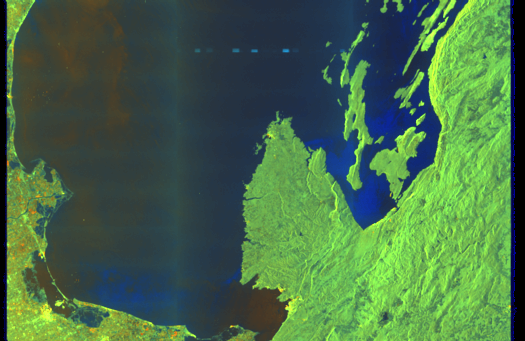

In [11]:
from IPython.display import display, Image

Image(os.path.join(product_path, 'preview/quick-look.png'))

## Post-process the products with *SNAP*

First, we reduce the working area to a smaller one contained into the gulf. We add to the product the vector file, containing the sea-lands separation mask.

In [12]:
graph_subset = os.path.join(workspace, 'Subset.xml')
with open(graph_subset, 'w') as g_1:
    g_1.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="Subset">
      <operator>Subset</operator>
      <sources>
        <sourceProduct refid="Apply-Orbit-File"/>
      </sources>
      <parameters>
        <region>500,500,15300,16600</region>
        <copyMetadata>true</copyMetadata>
      </parameters>
    </node>
    <node id="Apply-Orbit-File">
      <operator>Apply-Orbit-File</operator>
      <sources>
        <sourceProduct refid="Read"/>
      </sources>
    </node>
    <node id="Import-Vector">
      <operator>Import-Vector</operator>
      <sources>
        <sourceProduct refid="Subset"/>
      </sources>
      <parameters>
        <vectorFile>${vectorfile}</vectorFile>
        <separateShapes>false</separateShapes>
      </parameters>
    </node>
    <node id="Write">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Import-Vector"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
      </parameters>
    </node>
</graph>
"""
)

Make sure to have the auxdata folder (including the Gulf of Trieste shapefile) in your workspace folder.

In [14]:
vector_file = os.path.join(workspace, 'auxdata', 'Gulf_of_Trieste_seamask_UTM33.shp')
# Before calling gpt, we must set the environment
# variable LD_LIBRARY_PATH to the current directory
os.environ['LD_LIBRARY_PATH'] = '.'

!gpt {graph_subset} -Pinputproduct={product_path} -Pvectorfile={vector_file} -Poutputproduct={os.path.join(workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_Orb')}

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 2.2.3 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.2.3 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.2.3 set to be used by SNAP.
Executing processing graph
INFO: org.hsqldb.persist.Logger: dataFileCache open start
....10%....20%....30%....40%....50%....60%....70%....80%....90% done.


Now we can compute the ships detection. We apply a tresholding, then a target detection, setting detection between 30 and 600m. Adaptive  thresholding  is  a  frequently  used  method  for  target  detection  in  SAR  imagery.  The underlying  assumption  is  that  targets appear  bright  on  dark  background.  The adaptive  thresholding algorithm  is  applied  in  moving  window.  For  each  pixel  under  test (central  pixel) a new  threshold value is calculated based on the statistical characteristics of its local background, if the pixel value is above the threshold the pixel is classified as target pixel.

In [15]:
graph_process = os.path.join(workspace, 'ShipDetection.xml')
with open(graph_process, 'w') as g_2:
    g_2.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="Land-Sea-Mask">
      <operator>Land-Sea-Mask</operator>
      <sources>
        <sourceProduct refid="Read"/>
      </sources>
      <parameters>
        <geometry>Gulf_of_Trieste_seamask_UTM33</geometry>
        <landMask>false</landMask>
        <useSRTM>false</useSRTM>
        <shorelineExtension>10</shorelineExtension>
      </parameters>
    </node>
    <node id="Calibration">
      <operator>Calibration</operator>
      <sources>
        <sourceProduct refid="Land-Sea-Mask"/>
      </sources>
      <parameters>
        <selectedPolarisations>VH,VV</selectedPolarisations>
        <outputSigmaBand>true</outputSigmaBand>
      </parameters>
    </node>
    <node id="AdaptiveThresholding">
      <operator>AdaptiveThresholding</operator>
      <sources>
        <sourceProduct refid="Calibration"/>
      </sources>
      <parameters>
        <targetWindowSizeInMeter>30</targetWindowSizeInMeter>
        <guardWindowSizeInMeter>500.0</guardWindowSizeInMeter>
        <backgroundWindowSizeInMeter>800.0</backgroundWindowSizeInMeter>
        <pfa>12.5</pfa>
      </parameters>
    </node>
    <node id="Object-Discrimination">
      <operator>Object-Discrimination</operator>
      <sources>
        <sourceProduct refid="AdaptiveThresholding"/>
      </sources>
      <parameters>
        <minTargetSizeInMeter>30</minTargetSizeInMeter>
        <maxTargetSizeInMeter>600</maxTargetSizeInMeter>
      </parameters>
    </node>
    <node id="Write1">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Object-Discrimination"/>
      </sources>
      <parameters>
        <file>${outputproduct1}</file>
      </parameters>
    </node>
    <node id="Write2">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Object-Discrimination"/>
      </sources>
      <parameters>
        <file>${outputproduct2}</file>
        <formatName>Geotiff</formatName>
      </parameters>
    </node>
</graph>
"""
)

In [16]:
!gpt {graph_process} -Pinputproduct={os.path.join(workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_Orb.dim')} -Poutputproduct1={os.path.join(workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_processed')} -Poutputproduct2={os.path.join(workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_processed')}

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 2.2.3 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.2.3 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.2.3 set to be used by SNAP.
Executing processing graph
INFO: org.hsqldb.persist.Logger: dataFileCache open start
....10%....20%....30%....40%....50%....60%....70%....80%....90% done.


Finally we generate a subset  off the port of Ravenna that we will use to visualize the output. 

In [17]:
graph_visu = os.path.join(workspace, 'vizualisation_ships.xml')
with open(graph_visu, 'w') as g_3:
    g_3.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="SubSet">
      <operator>Subset</operator>
      <sources>
        <sourceProduct refid="Read"/>
      </sources>
      <parameters>
        <region>0,1000,10000,10000</region>
      </parameters>
    </node>
    <node id="Terrain-Correction">
      <operator>Terrain-Correction</operator>
      <sources>
        <sourceProduct refid="SubSet"/>
      </sources>
      <parameters>
        <sourceBands>Sigma0_VH_ship_bit_msk</sourceBands>
        <nodataValueAtSea>False</nodataValueAtSea>
      </parameters>
    </node>
    <node id="Write">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Terrain-Correction"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
        <formatName>Geotiff</formatName>
      </parameters>
    </node>
</graph>
"""
)

In [18]:
!gpt {graph_visu} -Pinputproduct={os.path.join(workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_processed.dim')} -Poutputproduct={os.path.join(workspace, 'subset_visualization')}

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 2.2.3 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.2.3 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.2.3 set to be used by SNAP.
Executing processing graph
INFO: org.hsqldb.persist.Logger: dataFileCache open start
INFO: org.esa.snap.core.datamodel.Product: raster width 10000 not equal to 15300
INFO: org.esa.snap.core.datamodel.Product: raster width 16471 not equal to 10000
INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://skywatch-auxdata.s3-us-west-2.amazonaws.com/dem/SRTM90/tiff/srtm_39_03.zip
....10%....20%.INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://skywatch-au

We reproject the subset to Mercator to display it with an interactive map.

In [19]:
!rio warp {os.path.join(workspace, 'subset_visualization.tif')} {os.path.join(workspace, 'subset_visualization_3857.tif')} --dst-crs="EPSG:3857" --resampling="bilinear" --overwrite

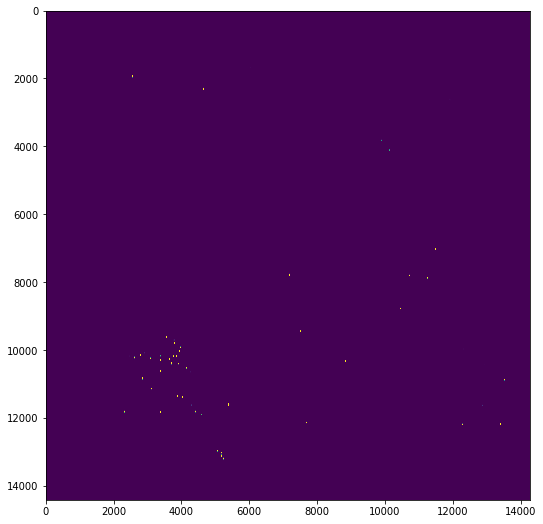

In [20]:
with rasterio.open(os.path.join(workspace, 'subset_visualization_3857.tif')) as triest_gulf_tif:
    triest_gulf = triest_gulf_tif.read(1)
# Display the image as is with matplotlib
plt.figure(figsize=(9, 9))
im = plt.imshow(triest_gulf, vmax=0.06)

Here we read a CSV file that contains the computed ship positions in the Gulf of Trieste and display them on an map. We can observe the concentration of detected ships nearby Ravenna harbor.

In [21]:
import csv
from itertools import islice

m = folium.Map([45, 13.6], zoom_start=8, tiles='openstreetmap')
with open(os.path.join(
    workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_processed.data',
    'vector_data', 'ShipDetections.csv'
), 'rt', encoding='utf-8') as data:
    for i in islice(csv.reader(data, delimiter='\t'), 2, None):
        folium.CircleMarker(
            [float(i[4]), float(i[5])], popup='Ship'
        ).add_to(m)
m

## Final results

We can add the subset we've done previously and display it to see if detection worked well.

In [22]:
triest_gulf = (triest_gulf * 255) / np.max(triest_gulf)
imageio.imwrite(os.path.join(workspace, 'triest_gulf.png'), triest_gulf)

Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


In [23]:
from folium.raster_layers import ImageOverlay

ImageOverlay(
    image=os.path.join(workspace, 'triest_gulf.png'),
    name='Mercator projection SW',
    bounds=[[44.1979166667, 12.1022944444], [45.2606388889, 13.5819333333]],
    opacity=0.9,
).add_to(m)

folium.LayerControl().add_to(m)
m

Some islets appear to have been wrongly detected. Now you can modify parameters in thresholding and detection processes in order to optimize ships detection.